## 1) Importing Libraries

In [12]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization, 
                                     Flatten, Dense, Dropout)

from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder

## 2) Data Loading

In [2]:
#Defining function for loading images from folder

def load_images_from_folder(folder):
    images = []
    names = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            names.append(filename)
    return images,names

In [3]:
train_data_Engine,train_label_Engine=load_images_from_folder(r'/kaggle/input/sections-final-dataset/sections/Engine_Nacelle')
train_data_Nose,train_label_Nose=load_images_from_folder(r'/kaggle/input/sections-final-dataset/sections/Nose')
train_data_Wings,train_label_Wings=load_images_from_folder(r'/kaggle/input/sections-final-dataset/sections/Wings')
train_data_Fuselage,train_label_Fuselage=load_images_from_folder(r'/kaggle/input/sections-final-dataset/sections/Fuselage')

## 3) Data Preprocessing

In [12]:
data = train_data_Engine + train_data_Nose + train_data_Wings + train_data_Fuselage

In [4]:
def scale_resize_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32) # equivalent to dividing image pixels by 255
    image = tf.image.resize(image, (64,64)) # Resizing the image to 224x224 dimention
    image /= 255.0
    image = np.expand_dims(image, axis=0)
    
    return (image)

In [13]:
for i in range(384):
    data[i]=scale_resize_image(data[i])

In [14]:
ml_data = np.empty([384,64,64,3])

for i in range(384):
    ml_data[i,:,:,:] = data[i]

In [31]:
ml_data.shape

(384, 64, 64, 3)

In [5]:
target = pd.DataFrame(['Engine' for i in range(len(train_data_Engine))] + 
                      ['Nose' for i in range(len(train_data_Nose))] \
                      + ['Wings' for i in range(len(train_data_Wings))] + 
                      ['Fuselage' for i in range(len(train_data_Fuselage))] )

target.columns=['section']

In [6]:
target

,section
0,Engine
1,Engine
2,Engine
3,Engine
4,Engine
...,...
379,Fuselage
380,Fuselage
381,Fuselage
382,Fuselage


In [7]:
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(target[['section']])
onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.categories_[0])
print(onehot_df)

     Engine  Fuselage  Nose  Wings
0       1.0       0.0   0.0    0.0
1       1.0       0.0   0.0    0.0
2       1.0       0.0   0.0    0.0
3       1.0       0.0   0.0    0.0
4       1.0       0.0   0.0    0.0
..      ...       ...   ...    ...
379     0.0       1.0   0.0    0.0
380     0.0       1.0   0.0    0.0
381     0.0       1.0   0.0    0.0
382     0.0       1.0   0.0    0.0
383     0.0       1.0   0.0    0.0

[384 rows x 4 columns]


In [32]:
onehot_df

,Engine,Fuselage,Nose,Wings
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
379,0.0,1.0,0.0,0.0
380,0.0,1.0,0.0,0.0
381,0.0,1.0,0.0,0.0
382,0.0,1.0,0.0,0.0


## 4) Model Architecture

In [17]:
def create_custom_cnn(input_shape=(64, 64, 3)):
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # Second Conv Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # Third Conv Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # Fourth Conv Block
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # Flattening the layers
    model.add(Flatten())
    
    # Fully Connected Layer
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output Layer
    model.add(Dense(4, activation='softmax'))
    
    return model

model = create_custom_cnn(input_shape=(64, 64, 3))
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,490,052 (9.50 MB)

 Trainable params: 2,489,092 (9.50 MB)

 Non-trainable params: 960 (3.75 KB)

In [10]:
#Compiling the Model
adam = Adam(learning_rate=1e-04)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 5) Model Training


In [ ]:
history = model.fit(ml_data,onehot_df,
                 epochs=2000,
                 verbose=1,
                 shuffle = True,
                 validation_split=0.1
                 )

Epoch 1/2000


2024-05-24 14:57:08.235263: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.74267, expected 2.93226
2024-05-24 14:57:08.235316: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.81792, expected 3.00751
2024-05-24 14:57:08.235325: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.10301, expected 4.2926
2024-05-24 14:57:08.235333: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.26842, expected 3.45801
2024-05-24 14:57:08.235341: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.07757, expected 4.26716
2024-05-24 14:57:08.235348: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.13438, expected 4.32397
2024-05-24 14:57:08.235356: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.00142, expected 5.191
2024-05-24 14:57:08.235363: E external/local_xla/xla/servi

 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3626 - loss: 5.7411  

I0000 00:00:1716562634.120775     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716562634.142488     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-05-24 14:57:17.763345: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.16074, expected 2.41307
2024-05-24 14:57:17.763409: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.73574, expected 3.98808
2024-05-24 14:57:17.763426: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.5651, expected 3.81744
2024-05-24 14:57:17.763442: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.96677, expected 3.21911
2024-05-24 14:57:17.763457: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.21137, expected 4.4637
2024-05-24 14:57:17.763485: E external/local_x

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3664 - loss: 5.5842 

W0000 00:00:1716562657.338147     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-05-24 14:57:37.435500: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.88619, expected 2.10896
2024-05-24 14:57:37.435568: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.13342, expected 3.35619
2024-05-24 14:57:37.435578: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.93843, expected 3.1612
2024-05-24 14:57:37.435586: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.22358, expected 3.44635
2024-05-24 14:57:37.435593: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.29562, expected 3.51839
2024-05-24 14:57:37.435601: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.47745, expected 3.70022
2024-05-24 14:57:37.435608: E external/local_xla/xla/service/gpu/b

11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.3684 - loss: 5.5178 - val_accuracy: 0.0000e+00 - val_loss: 1.6784
Epoch 2/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4479 - loss: 2.5813 - val_accuracy: 0.0000e+00 - val_loss: 1.8311
Epoch 3/2000
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6875 - loss: 1.4964

W0000 00:00:1716562658.045313     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6472 - loss: 1.4494 - val_accuracy: 0.0000e+00 - val_loss: 1.3629
Epoch 4/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7776 - loss: 0.8283 - val_accuracy: 0.0000e+00 - val_loss: 1.6384
Epoch 5/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7695 - loss: 0.9088 - val_accuracy: 1.0000 - val_loss: 0.2033
Epoch 6/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7769 - loss: 0.6193 - val_accuracy: 1.0000 - val_loss: 0.0143
Epoch 7/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8573 - loss: 0.4003 - val_accuracy: 1.0000 - val_loss: 0.0166
Epoch 8/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8490 - loss: 0.4842 - val_accuracy: 1.0000 - val_loss: 0.0294
Epoch 9/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9096 - loss: 0.3051 - val_accuracy: 1.0000 - val_loss: 0.0470
Epoch 10/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8925 - loss: 0.2895 - val_accuracy: 1.0000

In [21]:
model.save('section_finalll.h5')

## 6) Model Loading and Testing

In [41]:
def scale_resize_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (64, 64))
    image=image/255.0
    image = np.expand_dims(image, axis=0)
    return (image)

In [14]:
model=load_model('/kaggle/input/fuly-final-model2/section_finalll.h5')

In [44]:
img=cv2.imread(r'/kaggle/input/sections-final-dataset/sections/Engine_Nacelle/144_2_JPG_jpg.rf.29122708983287c5c8d1b3cde9223d53.jpg')

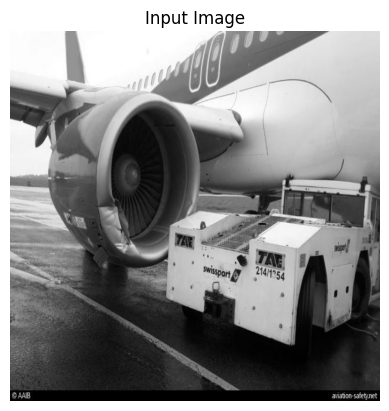

In [38]:
plt.imshow(img)
plt.title('Input Image')
plt.axis('off')  # Hide axes
plt.show()


In [45]:
img=scale_resize_image(img)

In [46]:
pred=model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


In [47]:
output_map = ['Engine','Fuselage','Nose','Wings']

In [50]:
print("The section where the plane is damaged is: ",output_map[np.argmax(pred)])

The section where the plane is damaged is:  Engine
